In [30]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
import xlwings as xw
import pandas as pd
import numpy as np
import os


# 그래프의 한글 깨짐 방지
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

"""설정정보 지정
    * 산출물 폴더 위치 및 엑셀파일내 sheet명
    * 데이터 컬럼 리스트 및 실제이터 시작 위치 지정
"""
target_folder = "d:/workspace/win/win/산출물폴더"
sheet_name = "Sheet1"
data_columns = ["업무", "상세기능", "단위기능", "담당자", "시작일", "종료일"]
start_row = 'A2'

## 특정 폴더내 산출물을 일괄 읽어 들임

In [31]:
    # 엑셀 파일 => frame_data로 변환
    file_list = os.listdir(target_folder)
    file_list = [f for f in file_list if f[0].isalnum()]

    df = None

    '''
    지정폴더 내에서 필요한 파일 리스트를 읽어서 데이터프레임으로 합친다
    '''
    for f in file_list:
        wb = xw.Book(os.path.join(target_folder, f))
        sheet = wb.sheets[sheet_name]
        d = sheet.range(start_row).options(pd.DataFrame, index=False, expand='table').value
        df = pd.DataFrame(d) if df is None else pd.concat([df, pd.DataFrame(d)], ignore_index=True)
        wb.close()
    df.columns = data_columns

## 전처리 과정 - 소요시간을 계산해서 셀 추가

In [32]:
    # 날짜 전처리
    df["시작일"].astype('datetime64[ns]')
    df["종료일"].astype('datetime64[ns]')
    df.insert(4, "소요시간", (df["종료일"] - df["시작일"]).dt.days)
    
    df


,업무,상세기능,단위기능,담당자,소요시간,시작일,종료일
0,A,A1,A12,홍길동,20,2021-02-01,2021-02-21
1,A,A2,A21,박세일,16,2021-02-05,2021-02-21
2,A,A2,A22,안창선,9,2021-02-01,2021-02-10
3,B,B1,B11,홍길동,16,2021-02-05,2021-02-21
4,B,B1,B12,박세일,9,2021-02-01,2021-02-10
...,...,...,...,...,...,...,...
62,A,A2,A22,안창선,20,2021-02-01,2021-02-21
63,B,B1,B11,홍길동,20,2021-02-01,2021-02-21
64,B,B1,B12,박세일,20,2021-02-01,2021-02-21
65,B,B2,B21,안창선,20,2021-02-01,2021-02-21


## 담당자별 개발물량 분석

<Figure size 432x288 with 0 Axes>

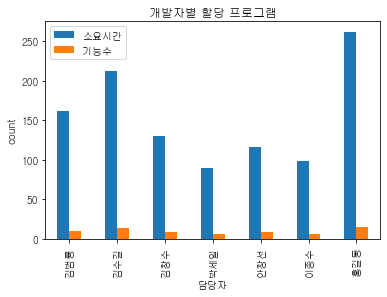

In [33]:
    # 담당자별 개발 기능 시리즈
    pfuncs = df["담당자"].value_counts()
    # 총 개발 기능 수
    sum_funcs = sum(df["담당자"].value_counts())
    # 개인별 평균 개발 기능수
    avg_funcs = np.mean(df["담당자"].value_counts())
    # 개발물량 제일 적은 사람
    p_min_funcs = (pfuncs.loc[pfuncs == df["담당자"].value_counts().min()])
    # 개발물량 제일 많은 사람
    p_max_funcs = (pfuncs.loc[pfuncs == df["담당자"].value_counts().max()])
    # 상위 10%와 하위 10%간의 개발물량 배수 계산
    df_g = df['소요시간'].groupby(df['담당자']).mean()
    up_f = (df_g.sort_values().head(round(df.shape[0] / 10)))
    lo_f = (df_g.sort_values().tail(round(df.shape[0] / 10)))
    amt_ratio = (lo_f.mean() / up_f.mean())

    psummary = df.groupby(['담당자']).agg(소요시간=('소요시간', 'sum'), 기능수=('상세기능', 'count'))
    # ax = sns.scatterplot(x='MySum', y='MyCount', hue="담당자", data=-gdf)

    # plot_df = df.groupby(["담당자","업무명"])[["담당자", "업무명"]].count()

    plt.figure()
    ax = psummary.plot.bar()
    plt.title("개발자별 할당 프로그램")
    plt.xlabel("담당자")
    plt.ylabel("count")
    p_figure = ax.get_figure()

## 특정 기능별 분석

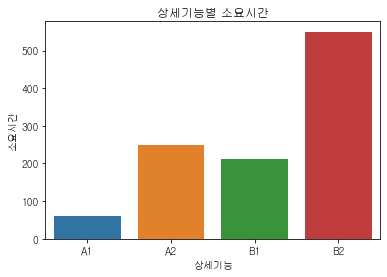

In [34]:
    import matplotlib.pyplot as plt
    # 업무별 개발 총 시간 분석
    df_g = df['소요시간'].groupby(df['상세기능']).mean()

    up_f = (df_g.sort_values().head(round(df.shape[0] / 10)))
    lo_f = (df_g.sort_values().tail(round(df.shape[0] / 10)))
    per_func_ratio = lo_f.mean() / up_f.mean()

    df_g = df['소요시간'].groupby(df['상세기능']).sum().reset_index()
    plt.figure()
    plt.xlabel("소요시간")
    plt.title("상세기능별 소요시간")
    ax = sns.barplot(x=df_g['상세기능'], y=df_g['소요시간'])
    f_figure = ax.get_figure()

In [35]:
    a_data = dict()
    a_data['raw_data'] = df
    a_data['p_min_funcs'], a_data['p_max_funcs'], a_data['amt_ratio'], a_data['p_plot'], \
            a_data['psummary'], a_data['f_plot'] = p_min_funcs, p_max_funcs, amt_ratio,  p_figure, psummary, f_figure

## 레포트 생성(엑셀)

In [36]:
    bk = xw.Book()
    sh1 = bk.sheets(1)
    sh1.range("B1:B4").column_width = 15
    sh1['B2'].value = "Summary"
    sh1['B3'].value = "Max Amount"
    sh1['C3'].value = f"{a_data['p_max_funcs'].index[0]}"
    sh1['D3'].value = f"{a_data['p_max_funcs'][0]}"

    sh1['B4'].value = "Min Amount"
    sh1['C4'].value = f"{a_data['p_min_funcs'].index[0]}"
    sh1['D4'].value = f"{a_data['p_min_funcs'][0]}"

    sh1["A50"].options(pd.DataFrame, header=1, index=True, expand='table').value = a_data["psummary"]
    table_range = sh1.range('C5').expand()
    left = table_range.left + table_range.width + 1
    top = table_range.top
    sh1.pictures.add(a_data['p_plot'], name="개인별 그래프", update=True, left=left, top=top)

    table_range = sh1.range('C29').expand()
    left = table_range.left + table_range.width + 1
    top = table_range.top
    sh1.pictures.add(a_data['f_plot'], name="기능별 그래프", update=True, left=left, top=top)

    bk.save('리포트.xlsx')
    bk.close()
